## Read rimes database, normalize and save in hdf5

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage
import scipy
import sys
import os.path
import h5py

import cv2

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap


path = '../data/RIMES/'

In [2]:
sys.version

'3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

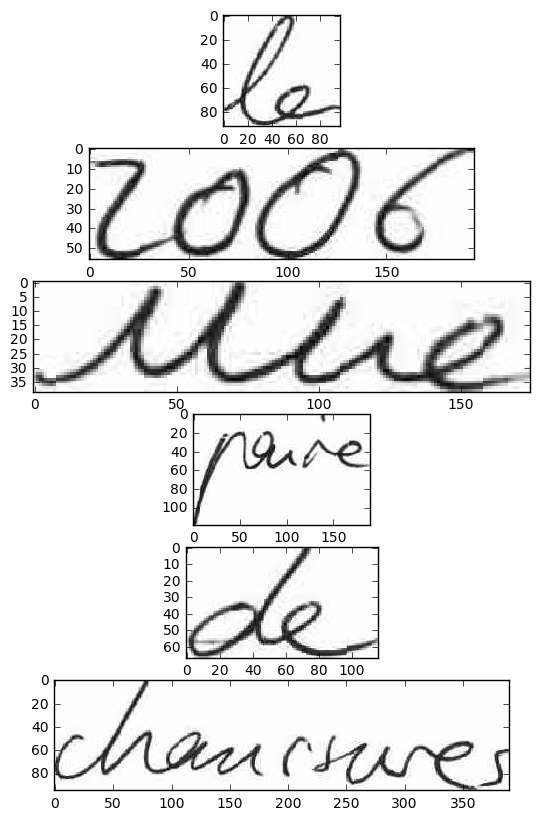

In [3]:
fig = plt.figure()
a=fig.add_subplot(6, 1, 1)
plt.imshow(cv2.imread(path + '/training/lot_1/00100_L/00100_L_1_0.tiff', cv2.IMREAD_GRAYSCALE))
a=fig.add_subplot(6, 1, 2)
plt.imshow(cv2.imread(path + '/training/lot_1/00100_L/00100_L_1_2.tiff', cv2.IMREAD_GRAYSCALE))
a=fig.add_subplot(6, 1, 3)
plt.imshow(cv2.imread(path + '/training/lot_1/00100_L/00100_L_1_3.tiff', cv2.IMREAD_GRAYSCALE))
a=fig.add_subplot(6, 1, 4)
plt.imshow(cv2.imread(path + '/training/lot_1/00100_L/00100_L_1_4.tiff', cv2.IMREAD_GRAYSCALE))
a=fig.add_subplot(6, 1, 5)
plt.imshow(cv2.imread(path + '/training/lot_1/00100_L/00100_L_1_5.tiff', cv2.IMREAD_GRAYSCALE))
a=fig.add_subplot(6, 1, 6)
plt.imshow(cv2.imread(path + '/training/lot_1/00100_L/00100_L_1_6.tiff', cv2.IMREAD_GRAYSCALE))

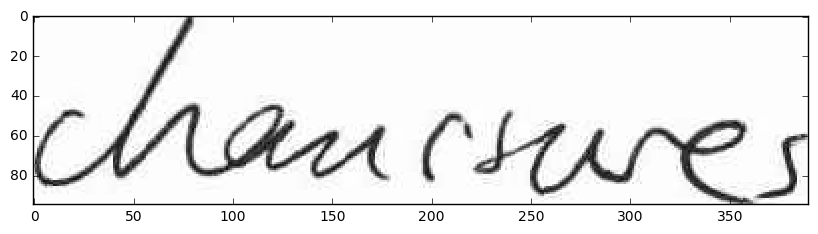

In [4]:
img = cv2.imread(path + '/training/lot_1/00100_L/00100_L_1_6.tiff', cv2.IMREAD_GRAYSCALE)
#print(img[60])
plt.imshow(img)

[  0   0   0   0   0  61 156 205 129  67   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  51 139 195 204 211 179  82   0   0   0   0   0
   0   0   0   0  25   0   0  58 133 176 191 199 135  68   0   0   0   0
   0   0   0   0   0  91 175 194 162  44   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  40 120 184 164  87   0   0   0   0   0
   0   0   0   0   0   0   0  80 159 199 200 181 154 133 219 202 186 194
 175  90   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  34  53 122 158 200 204 198 215 196 132  28   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  41 144 182 199 199 195 146  57   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  62 140 200 190 158  92   0   0   0   0   0   0   0   0   0   0   0
  35  99 177 183 101   0   0   0   0   0   0   0   0   0   0   0   0  75
 184 187  99   0   0   0   0   0   0   0   0   0   

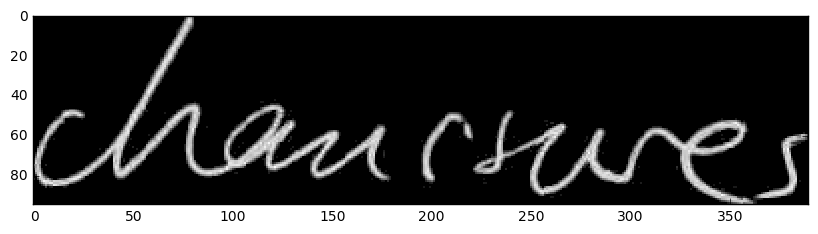

In [5]:
gray_level = np.vectorize(lambda x: 0 if x > 230 else 255-x)
img2 = gray_level(img)

print(img2[60])
plt.imshow(img2)
print(img2.shape)

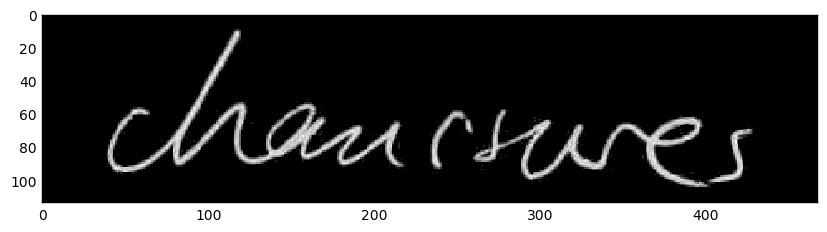

In [6]:
# Add border
h, w = img2.shape
dh = int(h*0.1)
dw = int(w*0.1)
img3 = np.zeros([h+2*dh, w+2*dw], dtype=np.uint8)
img3[dh:-dh, dw:-dw] = img2
plt.imshow(img3)

188


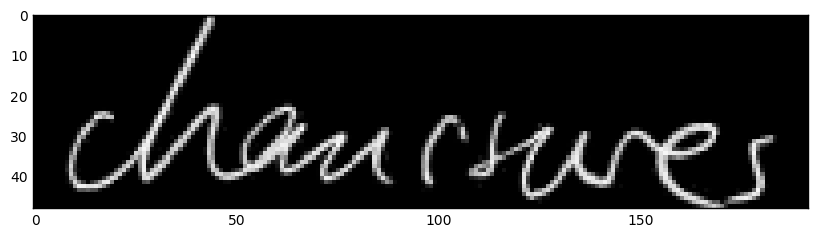

In [7]:
# The final shape must be 48 x 192
# if w > h*4 --> resize to (h, h*4)
# else complete at the left with 0
# Next resize to 48x192

def transform_image(img, x_size=192, y_size=48):

    # add treshold
    gray_level = np.vectorize(lambda x: 0 if x > 230 else 255-x)
    img2 = gray_level(img)

    # Add borders
    h, w = img2.shape
    dh = int(h*0)
    dw = int(w*0.05)
    img3 = np.zeros([h+2*dh, w+2*dw], dtype=np.uint8)
    img3[:, dw:-dw] = img2

    # Resize
    h, w = img3.shape
    if w >= h*4:
        img4 = cv2.resize(img3, (h*4, h)) #shape in cv2 is [w,h]
    else:
        img4 = np.zeros([h, h*4], dtype=np.uint8)
        img4[:, 0:w] = img3
    img5 = cv2.resize(img4, (x_size, y_size)) 
    
    # Calculate length of the image: The last non-zero column + 5 
    col_sum = np.sum(i for i in img5)
    for i, s in enumerate(col_sum):
        if s > 1:
            last_place = i
    img_len = min(x_size, 5+last_place)
    return img5, img_len

img_t, img_len = transform_image(img)
plt.imshow(img_t)
print(img_len)

## Transform image 

array([253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253,
       253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 235, 236,
       255, 226, 137,  98,  88,  48,  69, 160, 237, 227, 148,  71,  63,
       101, 161, 206, 250, 255, 251, 248, 251, 253, 253, 250, 245, 255,
       249, 180,  94,  64, 135, 217, 255, 244, 245, 251, 245, 245, 255,
       231, 176, 101,  46,  64, 153, 239, 242, 248, 251, 249, 246, 247,
       252, 255, 245, 224, 127,  68,  72, 137, 234, 254, 249, 249, 250,
       251, 251, 252, 253, 253, 253, 253, 253, 253], dtype=uint8)

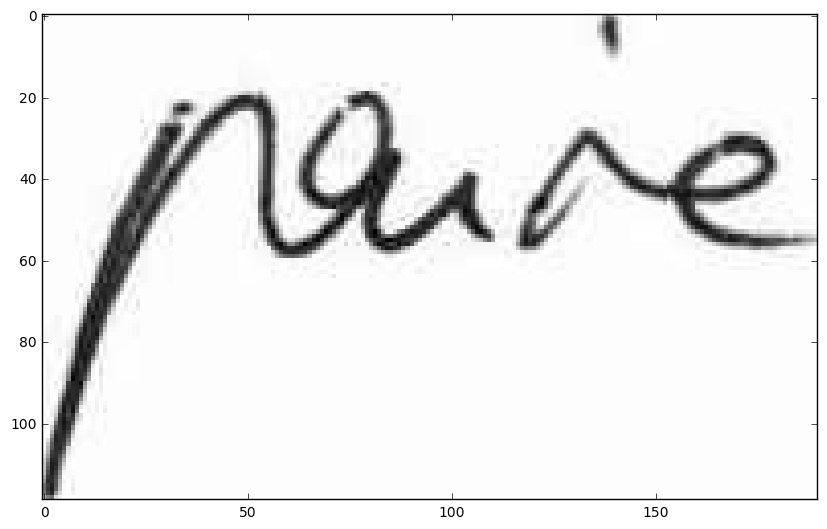

In [8]:
# Read image
img = cv2.imread(path + '/training/lot_1/00100_L/00100_L_1_4.tiff', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
img[30,:100]


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       115, 190, 132, 187, 129,   0,   0,   0,   0,   0,   0,   0, 147,
        89,   0,   5, 163, 103,   0,   0,   0,   0,  60, 203, 207, 174,
         1,   0,   0,   0,   0,   0,  40,   0,   0,   0,   0,   0,   0,
         0,   4, 147,  95,   0,   0,   1,  69, 194, 121,  18,   0,   0,
         0,  52, 197, 172,  17,   0,   0,   0,   0, 118, 177,  26,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

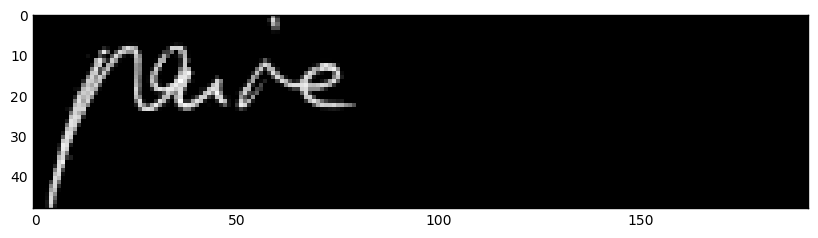

In [9]:
img1, img_len = transform_image(img)
plt.imshow(img1)
img1[15,:100]


Using TensorFlow backend.


array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,  115.,  190.,  132.,  187.,  129.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,  147.,   89.,
          0.,    5.,  163.,  103.,    0.,    0.,    0.,    0.,   60.,
        203.,  207.,  174.,    1.,    0.,    0.,    0.,    0.,    0.,
         40.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    4.,
        147.,   95.,    0.,    0.,    1.,   69.,  194.,  121.,   18.,
          0.,    0.,    0.,   52.,  197.,  172.,   17.,    0.,    0.,
          0.,    0.,  118.,  177.,   26.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])

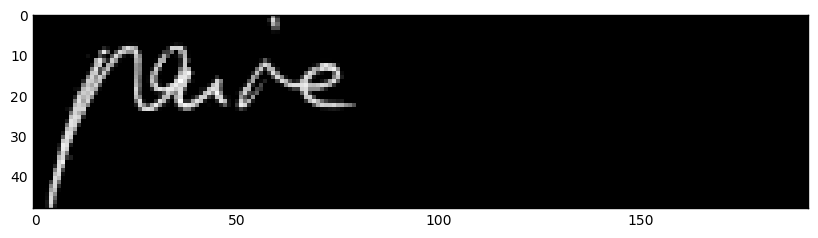

In [10]:
from sample_generator import SampleGenerator

sg = SampleGenerator(np.zeros([0,0]), np.zeros([0]), 0)
img3 = SampleGenerator._tranform_image(sg, img1, [sg.Transformation.MOVE,
                                                  sg.Transformation.DILATE, sg.Transformation.EROSION], 255.0)
plt.imshow(img3)
img3[15,:100]

In [11]:
# Import labels
labels_trn = pd.read_csv(path + 'groundtruth_training_icdar2011.txt', delimiter=' ', header=None, names=['file', 'label'])
print(labels_trn)

labels_val = pd.read_csv(path + 'ground_truth_validation_icdar2011.txt', delimiter=' ', header=None, names=['file', 'label'])
labels_tst = pd.read_csv(path + 'grount_truth_test_icdar2011.txt', delimiter=' ', header=None, names=['file', 'label'])


                                  file           label
0      ﻿lot_1/00001_L/00001_L_0_0.tiff           Suite
1       lot_1/00001_L/00001_L_2_0.tiff       meilleurs
2       lot_1/00001_L/00001_L_2_2.tiff          marche
3       lot_1/00001_L/00001_L_2_3.tiff          suivre
4       lot_1/00001_L/00001_L_2_4.tiff            pour
5       lot_1/00002_L/00002_L_0_0.tiff              Il
6       lot_1/00002_L/00002_L_0_1.tiff               y
7       lot_1/00002_L/00002_L_0_2.tiff               a
8       lot_1/00002_L/00002_L_0_3.tiff            mois
9       lot_1/00002_L/00002_L_0_4.tiff              le
10      lot_1/00002_L/00002_L_0_5.tiff             Mai
11      lot_1/00002_L/00002_L_0_7.tiff            très
12      lot_1/00002_L/00002_L_2_0.tiff           femme
13      lot_1/00002_L/00002_L_2_1.tiff             qui
14      lot_1/00002_L/00002_L_2_3.tiff        Celle-ci
15      lot_1/00002_L/00002_L_2_4.tiff               a
16      lot_1/00002_L/00002_L_2_5.tiff            donc
17      lo

In [12]:
print(labels_trn.shape)
print(labels_val.shape)
print(labels_tst.shape)


(51739, 2)
(7464, 2)
(7776, 2)


In [13]:
print(max(len(i) for i in labels_trn.label))
print(max(len(i) for i in labels_val.label))
print(max(len(i) for i in labels_tst.label))

19
16
18


In [14]:
# Test content
words = ''
for w in labels_trn.iloc[:10000].iterrows():
    words = words + ' # '+ w[1][1]
words

" # Suite # meilleurs # marche # suivre # pour # Il # y # a # mois # le # Mai # très # femme # qui # Celle-ci # a # donc # fait # l'objet # d'une # expertise # elle # a # moins # et # est # plus # nerveuse # mais # je # ne # peux # pas # avec # tout # ce # que # faisais # avec # la # mienne # qui # a # une # plus # grosse # cylindrée # Je # trouve # par # ailleurs # qu'un # mois # ça # fait # long # pour # une # Je # me # demande # ce # que # fait # l'expert # que # vous # comprendrez # mon # et # que # vous # ferez # votre # possible # pour # me # la # rendre # maintenant # dans # les # meilleurs # délais # de # façon # ce # que # je # puisse # faire # toutes # réparations # nécessaires # le # plus # vite # possible # Veuillez # Monsieur # Madame # l'expression # de # mes # sentiments # respectueux # Mon # courrier # dernier # est # resté # sans # réponse # de # votre # part # je # permets # de # vous # rappeler # demande # bien # voir # Dans # votre # veuillez # Monsieur # l'expressi

In [15]:
# Delete words with only numbers y/o capital letters and delete duplicates and save train lexicon.
trn_set = set()
trn_excluded = set()
for w in labels_trn.iloc[:].iterrows():
    counter=0
    for c in w[1][1]:
        if str.isdigit(c) or str.isupper(c):
            counter += 1
    if counter == len(w[1][1]):
        trn_excluded.add(w[1][1])
    else:
        trn_set.add(w[1][1])
print(trn_excluded)
print(len(trn_set))

# Save lexicon
import pickle
pickle.dump(list(trn_set), open(path + 'language_model/rimes_trn_lexicon.pkl', "wb" )) 



{'68', 'BONNO', 'TOUCHARD', '11H40', '8428', '91', 'YAAWL79', '8', '3', 'CAMARA', 'BRULER', 'OOOO', '2760', '185513', '57415', 'LWEDU32', 'RIGDY42', 'CZNUF04', '11', 'DXMWT', 'RMPZHZZ', 'OLIVER', 'RN67', '475', 'SCENIC', '38', 'LKHRN53', '99', 'BRETON', 'CD', '8CV', 'AI', 'PANDA', 'SGZFU06', 'QGJW073', '850', 'C2', '342', '4944', '76', 'NRDGU69', 'XXX', '03', 'UNRTS13', 'JNMKH58', 'F4', 'VIELLEFILLE', '75', '9', 'UN', 'MARTEL', 'BMP', 'ASCHBACH', 'AUTO', 'CODEVI', 'ZT99', 'DE', 'F', 'UMBNL58', '13', 'SCHWERDORFF', '30', 'XYZ', 'T40', 'SALESSE', 'NOUVELLES', '1997', '08250', 'AKN', '16', 'VILLAS', '29', '22', '05', 'TOIT', '4549', '52150', '2250', '80', 'C12', 'XZ225', '18', 'BORDEAUX', '72', 'COUQY29', 'PEL', '007', 'SALHI', '01', '700', 'MERCI', 'RMI', '34', 'MP3', '112', '33000', 'SAAB', 'LG', '93', 'OHLUNGEN', 'SACEM', 'BANSAC', '37', '567', '68480', '1507', 'NAIF', 'VFIPJ53', 'LILAS', 'ROCCHI', '234', '24', 'PMU', '300', 'ILLIMITEE', 'MAAWL', 'OOXP', 'QKCLJ47', 'YFMLM64', 'CV', '20

In [16]:
# Save labels as corpus to build and validate language models

def create_text(l):
    trn_list = list(l)
    trn_text = ''
    for i, w in enumerate(trn_list):
        trn_text += ' '+w
        if i%20==0:
            trn_text += '\n'
    return trn_text

with open(path + 'language_model/rimes_trn_corpus.txt', "a") as f:
    f.write(create_text(labels_trn.label))
with open(path + 'language_model/rimes_val_corpus.txt', "a") as f:
    f.write(create_text(labels_val.label))
with open(path + 'language_model/rimes_tst_corpus.txt', "a") as f:
    f.write(create_text(labels_tst.label))


In [17]:
# Create character dictionary encoder and decoder
def char_set(df):
    c_list = []
    for w in df.label:
        c_list += w
    return set(c_list)

s_trn = char_set(labels_trn)
s_val = char_set(labels_val)
s_tst = char_set(labels_tst)

print('trn - tst: ', s_trn - s_tst)
print('tst - trn: ', s_tst - s_trn)
print('trn - val: ', s_trn - s_val)
print('val - trn: ', s_val - s_trn)

char_set = s_trn

encoder_dict = {}
decoder_dict = {}
list_chars = []
list_codes = []
for i, c in enumerate(char_set):
    encoder_dict[c]=i
    decoder_dict[i]=c
    list_chars += [c.encode('utf8')]
    list_codes += [i]
    
print(encoder_dict)
print(decoder_dict)
print(list_chars)
print(list_chars[0].decode('utf8'))

trn - tst:  {'%', 'É', '²', 'ï', 'w'}
tst - trn:  set()
trn - val:  {'ù', 'É', 'ë', 'ï', '%', '²'}
val - trn:  set()
{'R': 8, 'a': 1, '2': 4, '4': 6, 't': 5, 'r': 19, "'": 7, 'e': 76, 'J': 0, 'F': 10, '3': 11, '8': 13, 'Y': 14, '5': 80, 's': 16, 'é': 18, 'q': 17, 'M': 20, 'S': 3, 'W': 22, 'h': 23, '6': 2, 'p': 24, 'n': 25, 'ô': 41, 'à': 27, '1': 28, 'G': 29, 'l': 30, 'ï': 72, '-': 73, 'y': 31, 'Z': 32, '²': 34, 'L': 35, 'î': 36, 'C': 37, 'ù': 42, 'B': 40, 'N': 67, 'w': 43, '7': 44, 'X': 45, '°': 46, 'ë': 47, 'H': 9, 'ç': 51, 'v': 50, 'â': 53, 'û': 56, 'I': 49, 'z': 55, '%': 33, 'c': 57, 'U': 64, 'o': 48, 'ê': 60, 'D': 61, 'i': 71, 'x': 62, 'j': 63, 'b': 66, 'è': 65, 'P': 52, 'k': 59, '/': 68, 'O': 69, '9': 58, 'A': 78, '0': 21, 'V': 70, 'd': 12, 'u': 79, 'T': 74, 'K': 75, 'Q': 15, 'g': 38, 'm': 77, 'É': 26, 'E': 39, 'f': 54}
{0: 'J', 1: 'a', 2: '6', 3: 'S', 4: '2', 5: 't', 6: '4', 7: "'", 8: 'R', 9: 'H', 10: 'F', 11: '3', 12: 'd', 13: '8', 14: 'Y', 15: 'Q', 16: 's', 17: 'q', 18: 'é', 1

# Read images and save in hdf5 files

In [18]:
X = []
image_length = []
target = []
target_length = []
names_of_files = []
max_target_len = 19

for i, row in labels_trn.iloc[:].iterrows():
    if i%1000==0:
        print(i)
    if os.path.isfile(path + '/training/' + row.file): 
        correct = True
        try:
            #Read image
            img = cv2.imread(path + '/training/' + row.file, cv2.IMREAD_GRAYSCALE)
            img_t, img_len = transform_image(img)        
            t = np.ones([max_target_len])*100
            for j, c in enumerate(row.label):
                t[j] = encoder_dict[c]
        except:
            correct = False
            print( 'Error in image ',i, row.file)
            print( 'Error: ', sys.exc_info()[0])
        if correct:
            X += [img_t]
            image_length += [img_len]
            target += [t]
            target_length += [len(row.label)]
            names_of_files += [row.file]
 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000


98 [  71.   25.   54.   48.   19.   77.   76.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.] 7 lot_2/00159_L/00159_L_0_2.tiff


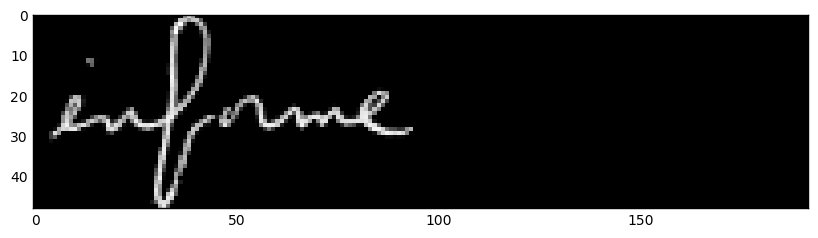

In [19]:
i=5900
plt.imshow(X[i])
print(image_length[i], target[i], target_length[i], names_of_files[i])

In [20]:


hdf5_f = h5py.File(path + "rimes_words_48_192.hdf5", mode='w')

if "target_dict_keys" in hdf5_f:
    del hdf5_f["target_dict_keys"]
hdf5_f.create_dataset("target_dict_keys", data = list_codes) 

if "target_dict_values" in hdf5_f:
    del hdf5_f["target_dict_values"]
hdf5_f.create_dataset("target_dict_values", data = list_chars) 


<HDF5 dataset "target_dict_values": shape (81,), type "|S2">

In [21]:
ds_type='trn'

if "X_"+ds_type in hdf5_f:
    del hdf5_f["X_"+ds_type]
hdf5_f.create_dataset("X_"+ds_type, data = X) 

if "image_length_"+ds_type in hdf5_f:
    del hdf5_f["image_length_"+ds_type]
hdf5_f.create_dataset("image_length_"+ds_type, data = image_length) 

if "target_"+ds_type in hdf5_f:
    del hdf5_f["target_"+ds_type]
hdf5_f.create_dataset("target_"+ds_type, data = target) 

if "target_length_"+ds_type in hdf5_f:
    del hdf5_f["target_length_"+ds_type]
hdf5_f.create_dataset("target_length_"+ds_type, data = target_length) 

if "filename_" + ds_type in hdf5_f:
    del hdf5_f["filename_" + ds_type]
names_of_files = [n.encode("ascii", "ignore") for n in names_of_files]
hdf5_f.create_dataset("filename_" + ds_type, (len(names_of_files),1), 'S20', data = names_of_files)  



<HDF5 dataset "filename_trn": shape (51738, 1), type "|S20">

In [22]:
X = []
image_length = []
target = []
target_length = []
names_of_files = []
max_target_len = 19

for i, row in labels_val.iloc[:].iterrows():
    if i%1000==0:
        print(i)
    if os.path.isfile(path + '/validation/' + row.file): 
        correct = True
        try:
            #Read image
            img = cv2.imread(path + '/validation/' + row.file, cv2.IMREAD_GRAYSCALE)
            img_t, img_len = transform_image(img)        
            t = np.ones([max_target_len])*100
            for j, c in enumerate(row.label):
                t[j] = encoder_dict[c]
        except:
            correct = False
            print( 'Error in image ',i, row.file)
            print( 'Error: ', sys.exc_info()[0])
        if correct:
            X += [img_t]
            image_length += [img_len]
            target += [t]
            target_length += [len(row.label)]
            names_of_files += [row.file]
 

0
1000
2000
3000
4000
Error in image  4700 lot_15/01483_L/01483_L_0_5.tiff
Error:  <class 'ValueError'>
5000
6000
7000


In [23]:
ds_type='val'

if "X_"+ds_type in hdf5_f:
    del hdf5_f["X_"+ds_type]
hdf5_f.create_dataset("X_"+ds_type, data = X) 

if "image_length_"+ds_type in hdf5_f:
    del hdf5_f["image_length_"+ds_type]
hdf5_f.create_dataset("image_length_"+ds_type, data = image_length) 

if "target_"+ds_type in hdf5_f:
    del hdf5_f["target_"+ds_type]
hdf5_f.create_dataset("target_"+ds_type, data = target) 

if "target_length_"+ds_type in hdf5_f:
    del hdf5_f["target_length_"+ds_type]
hdf5_f.create_dataset("target_length_"+ds_type, data = target_length) 

if "filename_" + ds_type in hdf5_f:
    del hdf5_f["filename_" + ds_type]
names_of_files = [n.encode("ascii", "ignore") for n in names_of_files]
hdf5_f.create_dataset("filename_" + ds_type, (len(names_of_files),1), 'S20', data = names_of_files)  


<HDF5 dataset "filename_val": shape (7463, 1), type "|S20">

In [24]:
X = []
image_length = []
target = []
target_length = []
names_of_files = []
max_target_len = 19

for i, row in labels_tst.iloc[:].iterrows():
    if i%1000==0:
        print(i)
    if os.path.isfile(path + '/test/' + row.file):
        correct = True
        try:
            #Read image
            img = cv2.imread(path + '/test/' + row.file, cv2.IMREAD_GRAYSCALE)
            img_t, img_len = transform_image(img)        
            t = np.ones([max_target_len])*100
            for j, c in enumerate(row.label):
                t[j] = encoder_dict[c]
        except:
            correct = False
            print( 'Error in image ',i, row.file)
            print( 'Error: ', sys.exc_info()[0])
        if correct:
            X += [img_t]
            image_length += [img_len]
            target += [t]
            target_length += [len(row.label)]
            names_of_files += [row.file]
            

0
1000
2000
3000
4000
5000
6000
7000


In [25]:
ds_type='tst'

if "X_"+ds_type in hdf5_f:
    del hdf5_f["X_"+ds_type]
hdf5_f.create_dataset("X_"+ds_type, data = X) 

if "image_length_"+ds_type in hdf5_f:
    del hdf5_f["image_length_"+ds_type]
hdf5_f.create_dataset("image_length_"+ds_type, data = image_length) 

if "target_"+ds_type in hdf5_f:
    del hdf5_f["target_"+ds_type]
hdf5_f.create_dataset("target_"+ds_type, data = target) 

if "target_length_"+ds_type in hdf5_f:
    del hdf5_f["target_length_"+ds_type]
hdf5_f.create_dataset("target_length_"+ds_type, data = target_length) 

if "filename_" + ds_type in hdf5_f:
    del hdf5_f["filename_" + ds_type]
names_of_files = [n.encode("ascii", "ignore") for n in names_of_files]
hdf5_f.create_dataset("filename_" + ds_type, (len(names_of_files),1), 'S20', data = names_of_files)  


<HDF5 dataset "filename_tst": shape (7776, 1), type "|S20">

In [26]:
hdf5_f.close()


In [27]:
# Check content
data_path = '/home/jorge/data/tesis/handwriting/p07_seq2seq/'


with h5py.File(data_path + "rimes_words_48_192.hdf5", "r") as hdf5_f:
    keys_dict = np.copy(hdf5_f["target_dict_keys"])
    values_dict = np.copy(hdf5_f["target_dict_values"])
    for date in hdf5_f.keys():
        print(hdf5_f[date].name)
        print(len(hdf5_f[date]))
        

/X_trn
51738
/X_tst
7776
/X_val
7463
/filename_trn
51738
/filename_tst
7776
/filename_val
7463
/image_length_trn
51738
/image_length_tst
7776
/image_length_val
7463
/target_dict_keys
81
/target_dict_values
81
/target_length_trn
51738
/target_length_tst
7776
/target_length_val
7463
/target_trn
51738
/target_tst
7776
/target_val
7463


In [28]:
decoder_dict={}
for i, key in enumerate(keys_dict):
    decoder_dict[key] = values_dict[i].decode('UTF-8')
decoder_dict

{0: 'J',
 1: 'a',
 2: '6',
 3: 'S',
 4: '2',
 5: 't',
 6: '4',
 7: "'",
 8: 'R',
 9: 'H',
 10: 'F',
 11: '3',
 12: 'd',
 13: '8',
 14: 'Y',
 15: 'Q',
 16: 's',
 17: 'q',
 18: 'é',
 19: 'r',
 20: 'M',
 21: '0',
 22: 'W',
 23: 'h',
 24: 'p',
 25: 'n',
 26: 'É',
 27: 'à',
 28: '1',
 29: 'G',
 30: 'l',
 31: 'y',
 32: 'Z',
 33: '%',
 34: '²',
 35: 'L',
 36: 'î',
 37: 'C',
 38: 'g',
 39: 'E',
 40: 'B',
 41: 'ô',
 42: 'ù',
 43: 'w',
 44: '7',
 45: 'X',
 46: '°',
 47: 'ë',
 48: 'o',
 49: 'I',
 50: 'v',
 51: 'ç',
 52: 'P',
 53: 'â',
 54: 'f',
 55: 'z',
 56: 'û',
 57: 'c',
 58: '9',
 59: 'k',
 60: 'ê',
 61: 'D',
 62: 'x',
 63: 'j',
 64: 'U',
 65: 'è',
 66: 'b',
 67: 'N',
 68: '/',
 69: 'O',
 70: 'V',
 71: 'i',
 72: 'ï',
 73: '-',
 74: 'T',
 75: 'K',
 76: 'e',
 77: 'm',
 78: 'A',
 79: 'u',
 80: '5'}